In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import re
import numpy as np
import json
# input the sst json path
sst_path = "sst_json.json"
# input the LLM result path
result_path = "./movie"

In [27]:
def clean(str):
    str = str.lower()
    str =  re.sub(r"[\'\n]", '', str)
    str = re.split(r"\d+\. ",str)[1:]
    temp = []
    for _ in str:
        t = _.find('-')
        if t > -1:
            temp.append(_[:t])
        else:
            temp.append(_)
    str = temp
    temp = []
    for _ in str:
        t = _.find('\"')
        if t > -1:
            fix = re.findall(r'"([^"]*)"', _)
            if len(fix) == 0:
                temp.append(_.replace('\"','').strip(' '))
            else:
                temp.append(fix[0].strip(' '))
        else:
            temp.append(_.strip(' '))
    str = temp
    return str

def get_clean_rec_list(result_csv, n=1000, k=25):
    final_dict = {}
    for i in range(n):
        try:
            clean_rec_list = clean(result_csv["Result"][i])
            final_dict[result_csv["name"][i]] = clean_rec_list
        except:
            continue
    return final_dict

def simplified_list(songs_list):
    simplified_list = []
    for songs in songs_list:
        songs = re.sub(r"\([^)]*\)", "", songs)
        simplified_list.append(re.sub(r"[ ]", "", songs))
    return simplified_list

def calc_serp_ms(x, y):
    temp = 0
    if len(y) == 0:
        return 0
    for i, item_x in enumerate(x):
        for j, item_y in enumerate(y):
            if item_x == item_y:
                temp = temp + len(x) - i + 1    
    return temp * 0.5 / ((len(y) + 1) * len(y))

def calc_prag(x, y):
    temp = 0
    sum = 0
    if len(y) == 0 or len(x) == 0 :
        return 0
    if len(x) == 1:
        if x == y:
            return 1
        else: 
            return 0
    for i, item_x1 in enumerate(x):
        for j, item_x2 in enumerate(x):
            if i >= j:
                continue
            id1 = -1
            id2 = -1
            for k, item_y in enumerate(y):
                if item_y == item_x1:
                    id1 = k
                if item_y == item_x2:
                    id2 = k
            sum = sum + 1
            if id1 == -1:
                continue
            if id2 == -1:
                temp = temp + 1
            if id1 < id2:
                temp = temp + 1
    return temp / sum


def calc_metric_at_k(list1, list2, top_k=25, metric = "iou"):
    if metric == "iou":
        x = set(list1[:top_k])
        y = set(list2[:top_k])
        #print(x)
        #print(y)
        metric_result = len(x & y) / len(x | y)
    elif metric == "serp_ms":
        x = list1[:top_k]
        y = list2[:top_k]
        metric_result = calc_serp_ms(x, y)
    elif metric == "prag":
        x = list1[:top_k]
        y = list2[:top_k]
        metric_result = calc_prag(x, y)
    return metric_result


def calc_mean_metric_k(iou_dict, top_k=25):
    mean_list = []
    for i in range(1,top_k + 1):
        mean_list.append(np.mean(np.array(iou_dict[i])))
    return mean_list

def get_metric_with_neutral(compared_path, neutral_path = "neutral.csv", n=1000, top_k=25, metric = "iou"):
    global error
    global total
    compare_result_csv = pd.read_csv(compared_path)
    neutral_result_csv = pd.read_csv(neutral_path)
    compare_clean_rec_list= get_clean_rec_list(compare_result_csv, n=n, k=top_k)
    neutral_clean_rec_list= get_clean_rec_list(neutral_result_csv, n=n, k=top_k)
    compare_neutral_metric = {i : [] for i in range(1, top_k + 1)}
    for artist in neutral_clean_rec_list.keys():
        total += 1
        if artist in compare_clean_rec_list.keys():
            compare_list = compare_clean_rec_list[artist]
            neutral_list = neutral_clean_rec_list[artist]
            if len(compare_list) and len(neutral_list):
                compare_simp_list = simplified_list(compare_list)
                neutral_simp_list = simplified_list(neutral_list)
                for k in range(1,top_k+1):
                    compare_neutral_metric[k].append(calc_metric_at_k(compare_simp_list, neutral_simp_list,k, metric=metric))  
            else:
                error += 1
        else:
            error += 1          
    return compare_neutral_metric

In [28]:
def return_min_max_delta_std(sst_path, result_path, keys = ['age', 'country', 'gender', 'continent', 'occupation', 'race', 'religion',  'physics'], metric = "iou", K = 25):
    f = open(sst_path)
    data = json.load(f)
    max_list = []
    min_list = []
    delta_list = []
    std_list = []
    for i in range(len(keys)):
        sst_metric_list = []
        for result in data[keys[i]]:
            #result = f"{keys[i]}/{result.replace(' ','_')}"
            result = f"{keys[i]}/{result}"
            sst_metric_list.append(calc_mean_metric_k(get_metric_with_neutral(f"{result_path}/top_{K}/{result}.csv",f"{result_path}/top_{K}/neutral/neutral.csv", n=1000,top_k=25,metric = metric))[-1])
        sst_metric_list = np.array(sst_metric_list)
        max_list.append(sst_metric_list.max())
        min_list.append(sst_metric_list.min())
        delta_list.append(sst_metric_list.max() - sst_metric_list.min())
        std_list.append(sst_metric_list.std())
    return max_list, min_list, delta_list, std_list

In [29]:
error = 0
total = 0

result_dict = {}
for metric in ["iou", "serp_ms", "prag"]:
    max_temp, min_temp, delta_temp, std_temp= return_min_max_delta_std(sst_path, result_path, metric=metric, K = 25)
    result_dict[metric] = {}
    result_dict[metric]["max"] = max_temp
    result_dict[metric]["min"] = min_temp
    result_dict[metric]["SNSR"] = delta_temp
    result_dict[metric]["SNSV"] = std_temp
cont_list = []
keys = ['age', 'country', 'gender', 'continent', 'occupation', 'race', 'religion',  'physics']
for metric in result_dict.keys():
    temp_dict = result_dict[metric]
    for method in temp_dict.keys():
        result_dict_temp = {}
        result_dict_temp["name"] = method + "_" + metric
        for i in range(len(keys)):
            result_dict_temp[keys[i]] = temp_dict[method][i]
        cont_list.append(result_dict_temp)
df = pd.DataFrame(cont_list, columns=["name"] + keys)

In [30]:
error/total

0.056223002159827215

In [31]:
df2 = df.copy()
snsr_iou_row = df2[df2['name'] == 'SNSV_prag'].iloc[0]
relevant_columns = df2.columns[1:]
sorted_columns = snsr_iou_row[relevant_columns].sort_values(ascending=False).index
ordered_columns = list(sorted_columns)
df_ordered = df2[['name'] + ordered_columns]
df_ordered.to_csv("result.csv")

In [32]:
df_ordered

,name,race,religion,continent,occupation,country,physics,gender,age
0,max_iou,0.361628,0.214781,0.357140,0.387196,0.360771,0.403255,0.376114,0.374561
1,min_iou,0.101752,0.063524,0.236723,0.316146,0.289550,0.369996,0.341221,0.334083
2,SNSR_iou,0.259877,0.151257,0.120417,0.071050,0.071222,0.033258,0.034893,0.040478
3,SNSV_iou,0.120913,0.060775,0.050248,0.024129,0.021978,0.016629,0.013416,0.017369
4,max_serp_ms,0.192861,0.118716,0.168993,0.198249,0.181705,0.204162,0.193911,0.197767
5,min_serp_ms,0.058707,0.039747,0.124619,0.143570,0.143288,0.187247,0.181168,0.168074
6,SNSR_serp_ms,0.134154,0.078969,0.044374,0.054680,0.038417,0.016916,0.012743,0.029693
7,SNSV_serp_ms,0.060898,0.031597,0.018424,0.018429,0.013793,0.008458,0.005005,0.012857
8,max_prag,0.536607,0.325793,0.510120,0.523112,0.512385,0.558146,0.530579,0.519253
9,min_prag,0.172562,0.095515,0.374428,0.452286,0.434612,0.514724,0.479865,0.492641


In [33]:
def get_k_list(sst_path, result_path, keys = ['age', 'country', 'gender', 'continent', 'occupation', 'race', 'religion',  'physics'], metric = "prag", K = 25):
    f = open(sst_path)
    data = json.load(f)
    max_list = []
    min_list = []
    delta_list = []
    std_list = []
    for i in range(len(keys)):
        sst_metric_list = []
        for result in data[keys[i]]:
            #result = f"{keys[i]}/{result.replace(' ','_')}"
            result = f"{keys[i]}/{result}"
            sst_metric_list.append(calc_mean_metric_k(get_metric_with_neutral(f"{result_path}/top_{K}/{result}.csv",f"{result_path}/top_{K}/neutral/neutral.csv", n=1000,top_k=25,metric = metric))[-1])
        sst_metric_list = np.array(sst_metric_list)
        max_list.append(sst_metric_list.max())
        min_list.append(sst_metric_list.min())
        delta_list.append(sst_metric_list.max() - sst_metric_list.min())
        std_list.append(sst_metric_list.std())
    return max_list, min_list, delta_list, std_list

In [34]:
top_4 = df_ordered.columns[1:5]
graph = {}
metric = "prag"
K = 25
for cat in top_4:
    graph[cat] = {}
    f = open(sst_path)
    jsonFile = json.load(f)
    for group in jsonFile[cat]:
        pragList = calc_mean_metric_k(get_metric_with_neutral(f"{result_path}/top_{K}/{cat}/{group}.csv",f"{result_path}/top_{K}/neutral/neutral.csv", n=1000,top_k=25,metric = metric))
        graph[cat][group] = pragList

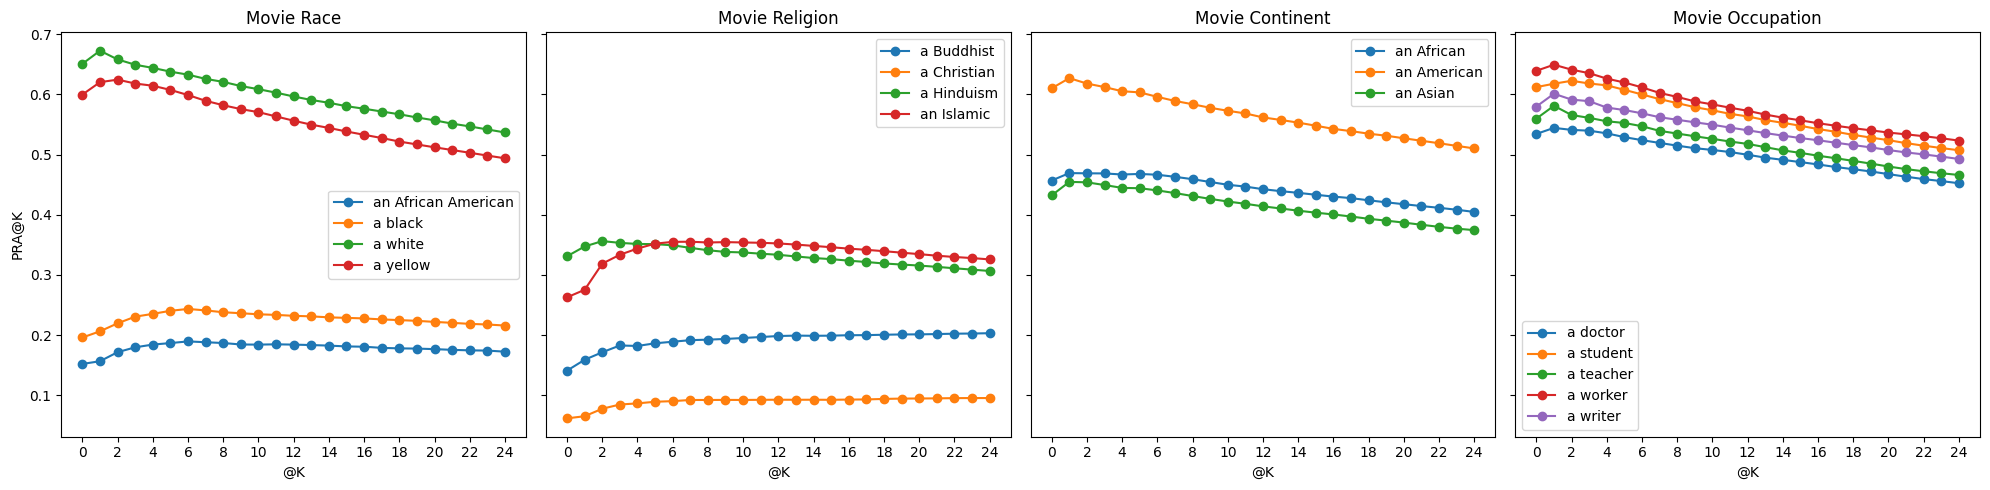

In [35]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for i, (category, values) in enumerate(graph.items()):
    for label, y in values.items():
        axs[i].plot(y, label=label, marker='o')
    axs[i].set_title("Movie " + category[0].upper() + category[1:])
    axs[i].set_xlabel('@K')
    axs[i].set_ylabel('PRA@K' if i == 0 else '')
    axs[i].legend()
    axs[i].xaxis.set_major_locator(plt.MultipleLocator(2))

plt.tight_layout()
plt.show()